## Training a CNN

In this lab we are going to be working with a ["17 Category Flower Dataset"](https://www.robots.ox.ac.uk/~vgg/data/flowers/17/index.html) from Visual Geometry Group of Oxford University.
We will acquire the data, split it, train multiple models and do some vizualizations. 

In [1]:
import numpy as np 
import pandas as pd 
import os
import shutil 

### 1. Data aquisition

First, let's download the data from the webpage. You could have done it manually by going to the page, but we'll do it in the script.

In [2]:
import urllib

In [3]:
dataset_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz"
split_description_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/17/datasplits.mat"
#segmentation_ground_truth_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/17/trimaps.tgz"
readme_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/17/README.txt"

First, let's download the README file

In [4]:
# create folder to store data
data_folder = "data/"
os.makedirs(data_folder, exist_ok=True)

In [5]:
# let's write a function to download data as we'll use multiple times
def get_file(file_url, target_folder=""):
    filename = os.path.basename(file_url)
    # express explicitly the filepath where data will be downloaded
    target_filepath = os.path.join(target_folder, filename)
    filepath, response = urllib.request.urlretrieve(file_url, target_filepath)
    
    return filepath, response

In [6]:
# download readme file
readme_filepath, response = get_file(readme_url, data_folder)

In [7]:
# Check out the README
with open(readme_filepath, 'r') as readme:
    text = readme.read()
    print(text)

17 Flower Category Database
----------------------------------------------
This set contains images of flowers belonging to 17 different categories. 
The images were acquired by searching the web and taking pictures. There are
80 images for each category. 

The database was used in:

Nilsback, M-E. and Zisserman, A.  A Visual Vocabulary for Flower Classification.
Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (2006) 
http://www.robots.ox.ac.uk/~vgg/publications/papers/nilsback06.{pdf,ps.gz}.

The datasplits used in this paper are specified in datasplits.mat

There are 3 separate splits. The results in the paper are averaged over the 3 splits.
Each split has a training file (trn1,trn2,trn3), a validation file (val1, val2, val3)
and a testfile (tst1, tst2 or tst3). 

Segmentation Ground Truth
------------------------------------------------
The ground truth is given for a subset of the images from 13 different
categories. 

More details can be found in:

Ni

Now, let's download the data

In [8]:
# download the data
# dataset_filepath, response = get_file(dataset_url, data_folder)

We have just downloaded a tar file. Let's unpack it.

In [9]:
import tarfile

In [10]:
# with tarfile.open(dataset_filepath) as tar:
#     tar.extractall(path=data_folder)

What have we extracted? 

In [11]:
os.listdir(data_folder)

['.ipynb_checkpoints',
 '17flowers.tgz',
 'datasplits.mat',
 'jpg',
 'README.txt',
 'training_folder']

We see that a new folder named *jpg* has appeared.

In [12]:
os.listdir(os.path.join(data_folder, 'jpg'))[:10]

['.ipynb_checkpoints',
 'files.txt',
 'files.txt~',
 'image_0001.jpg',
 'image_0002.jpg',
 'image_0003.jpg',
 'image_0004.jpg',
 'image_0005.jpg',
 'image_0006.jpg',
 'image_0007.jpg']

This folder contains images of the dataset. But what about ground truth?

Based on the README, each class contains exactly 80 images. Quick check shows that images of one class are grouped together. We will use this fact later to group the images by class.

The split information was already provided with the dataset (otherwise we could have used train_test_split to obtain it)

In [13]:
# download split file
split_filepath, response = get_file(split_description_url, data_folder)

In [14]:
from scipy.io import loadmat
split = loadmat(split_filepath)

In [15]:
split.keys()

dict_keys(['__header__', '__version__', '__globals__', 'trn1', 'trn2', 'trn3', 'tst1', 'tst2', 'tst3', 'val3', 'val2', 'val1'])

Let's use option 1 of train/val/test split:

In [16]:
train = split["trn1"]
val = split["val1"]
test = split["tst1"]

print("""Train set contains {} files, 
val set contains {} files, 
and test set contains {} files""".format(train.shape[1], val.shape[1], test.shape[1]))


Train set contains 680 files, 
val set contains 340 files, 
and test set contains 340 files


##### Excercise
Additional things to do:
- Check how many images we have downloaded.
- Display some of the images.
- Are those color images? 
- What are their shape? 
- Are they all of the same shape?

In [17]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 
import random
random.seed(42)

In [18]:
files=[]
for name in os.listdir(os.path.join(data_folder, 'jpg')):
    if name.endswith(".jpg"):
            files.append(name)

In [19]:
print(len(files), 'images are downloaded.')

1360 images are downloaded.


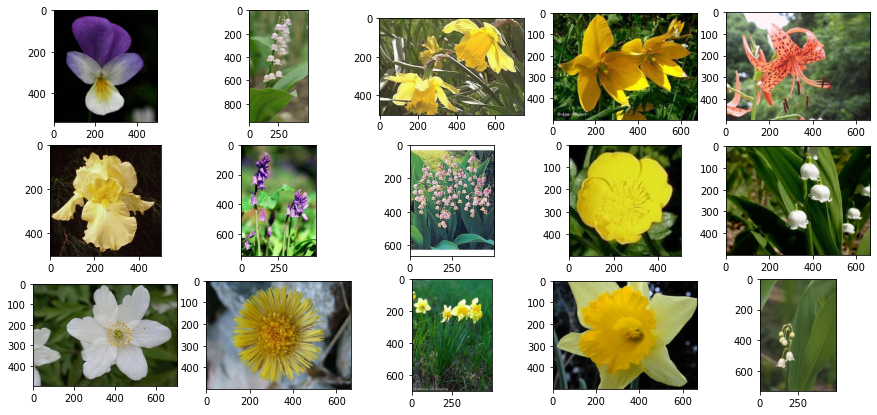

In [20]:
plt.figure(figsize = (15, 7))

for i, filename in enumerate(random.sample(files, 15)):
    plt.subplot(3, 5, i+1)

    img = mpimg.imread(os.path.join(data_folder, f'jpg/{filename}'))
    plt.imshow(img) 

It can be seen from the images I displayed, that those pictures are colorful and have different shapes.

### 2. Data regrouping

During the training with Keras for the simplicity we are going to be using flow_from_dir method of ImageDataGenerator. However, we'll need to organize data first in the specific manner: separate train, val, test sets, and put images of each class in a designated folder. 


First, let's write a function to get a class name from file index. We'll use the fact that each class has 80 images, and they are grouped together by index. 

In [21]:
def get_image_class(file_index):
    image_class_idx = (int(file_index) - 1) // 80 + 1
    class_name = "{:02d}".format(image_class_idx)
    
    return class_name

Now let's rearrange the data

In [22]:
from shutil import copy

In [23]:
training_folder_name = "training_folder"

In [24]:
for filename in os.listdir(os.path.join(data_folder, 'jpg')):
    if filename.endswith('jpg'):
        ### filename 'image_0936.jpg' --> file_index 936
        file_index = int(filename[6:10])
        true_class = get_image_class(file_index)
        if file_index in train:
            split_folder = 'train'
        elif file_index in val:
            split_folder = 'val'
        elif file_index in test:
            split_folder = 'test'     
        
        target_folder = os.path.join(data_folder, training_folder_name, split_folder, true_class)
        os.makedirs(target_folder, exist_ok=True)
        
        source_filepath = os.path.join(data_folder, 'jpg', filename)
        copy(source_filepath, target_folder)
    else:
        print(filename)
        print("Not a jpg file, skipping")
    

.ipynb_checkpoints
Not a jpg file, skipping
files.txt
Not a jpg file, skipping
files.txt~
Not a jpg file, skipping


### 3. CNN training

Now that we have prepared the data, we will be able to train a model.

#### 3.1 Transfer learning

Let's do the [transfer learning](https://papers.nips.cc/paper/5347-how-transferable-are-features-in-deep-neural-networks.pdf) we have briefly discussed last time. We'll load one of the pretrained models from Keras library with [ImageNet weights](http://www.image-net.org/).

##### Model preparation

In [25]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(42)

import os

Using TensorFlow backend.
/home/daryna/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/daryna/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/daryna/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/daryna/.local/lib/python3.7/site-packages/tensorflow/python

In [26]:
# GPU selection --> execute do only if you need to select a GPU / part of GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

### Set session with share of GPU
config_1 = tf.ConfigProto()
gpu_fraction_1 = float(os.environ.get('GPU_LIMIT_1', 0.95))
config_1.gpu_options.per_process_gpu_memory_fraction = gpu_fraction_1
config_1.gpu_options.allow_growth = True

sess_1 = tf.Session(config=config_1)
sess_1.run(tf.global_variables_initializer())
K.set_session(sess_1);


We'll be using VGG16 model. Together with weights, we'll also need a corresponding preprocessing function for the input images.

In [27]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg

from keras.layers import Dense, Dropout, Flatten
from keras.models import Model

In [28]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape = (224,224,3))
base_model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0    

Note that we have downloaded only a convolution part of the neural network. Let's add some dense layers on top of it.

In [29]:
## freezing the layers

#for layer in base_model.layers:
#    layer.trainable = False

In [30]:
nb_classes = 17

In [31]:
flatten = Flatten()(base_model.output)
dropout_1 = Dropout(0.25)(flatten)
fc_1 = Dense(1000)(dropout_1)
dropout_2 = Dropout(0.5)(fc_1)
predictions = Dense(nb_classes, activation="softmax", name='predictions')(dropout_2)

In [32]:
model = Model(input=base_model.input, output=predictions)

/home/daryna/anaconda3/envs/ml_ukma/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  """Entry point for launching an IPython kernel.


In [33]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

##### Model training parameters

In [34]:
from keras import optimizers

In [35]:
loss = 'categorical_crossentropy'
learning_rate = 0.001
optimizer = optimizers.SGD ## optimizers.SGD ## optimizers.RMSprop ## optimizers.Adagrad ## optimizers.Adadelta
metrics = ['accuracy']

In [36]:
model.compile(loss=loss,
              optimizer=optimizer(learning_rate),
              metrics=metrics)

##### Data preparation

In [37]:
from keras.preprocessing.image import ImageDataGenerator

In [38]:
train_dir = os.path.join(data_folder, training_folder_name, "train")
val_dir = os.path.join(data_folder, training_folder_name, "val")
test_dir = os.path.join(data_folder, training_folder_name, "test")

In [39]:
# we'll resize images in correspondance to network input size
image_size = (224,224)

In [40]:
# apply some data augmentation
train_datagen = ImageDataGenerator(rotation_range=15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   preprocessing_function=preprocess_input_vgg
                                  )

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg) # for validation we don't need to augment

train_batchsize = 30
val_batchsize = 30

# this function takes images from folders and feeds to Imagedatagenerator
train_generator = train_datagen.flow_from_directory( 
        train_dir,
        target_size=image_size,
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        target_size=image_size,
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 680 images belonging to 17 classes.
Found 340 images belonging to 17 classes.


##### Model training

In [41]:
epochs = 50

In [42]:
nb_train_steps = train_generator.samples // train_generator.batch_size
nb_val_steps = validation_generator.samples // validation_generator.batch_size

In [43]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=nb_train_steps,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=nb_val_steps,
      verbose=1, #0
)


Epoch 1/50
22/22 [==============================] - 15s 663ms/step - loss: 5.3156 - accuracy: 0.0338 - val_loss: 2.8815 - val_accuracy: 0.0545
Epoch 2/50
22/22 [==============================] - 9s 405ms/step - loss: 2.8358 - accuracy: 0.0538 - val_loss: 2.8299 - val_accuracy: 0.0097
Epoch 3/50
22/22 [==============================] - 8s 385ms/step - loss: 2.8308 - accuracy: 0.0492 - val_loss: 2.8369 - val_accuracy: 0.0387
Epoch 4/50
22/22 [==============================] - 9s 387ms/step - loss: 2.8225 - accuracy: 0.0600 - val_loss: 2.8372 - val_accuracy: 0.0645
Epoch 5/50
22/22 [==============================] - 9s 392ms/step - loss: 2.8125 - accuracy: 0.0636 - val_loss: 2.7177 - val_accuracy: 0.0581
Epoch 6/50
22/22 [==============================] - 9s 388ms/step - loss: 2.8030 - accuracy: 0.0844 - val_loss: 2.8239 - val_accuracy: 0.0387
Epoch 7/50
22/22 [==============================] - 9s 398ms/step - loss: 2.8058 - accuracy: 0.0818 - val_loss: 2.7842 - val_accuracy: 0.0645
Epoc

In [44]:
print('training acc.:',history.history['accuracy'][-1])
print('val acc.:', (history.history['val_accuracy'])[-1])

training acc.: 0.5469697
val acc.: 0.5806451439857483


In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy %')
    plt.plot(history.epoch, np.array(history.history['accuracy']),
    label='Train Accuracy')
    plt.plot(history.epoch, np.array(history.history['val_accuracy']),
    label = 'Val Accuracy')
    plt.legend()
    plt.ylim([0, 1])

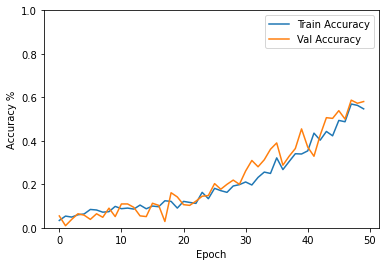

In [46]:
plot_history(history)

##### Save model

In [47]:
weights_folder = "weights"
os.makedirs(weights_folder, exist_ok=True)

In [48]:
model_name = 'vgg16_transfer_weights.h5'

In [49]:
model_path = os.path.join(weights_folder, model_name)

In [50]:
# uncomment to save model
model.save(model_path)

##### Do the test on images

In [51]:
from keras.preprocessing import image
from keras.models import load_model

In [52]:
model = load_model(model_path, compile=False)

###### Single image prediction

In [53]:
#test_dir = "data/training_folder/test"
#image_size = (224,224)

In [54]:
class_idx = '08'
image_name = os.listdir(os.path.join(test_dir, class_idx))[0]
image_path = os.path.join(test_dir, class_idx, image_name)

In [55]:
image_path

'data/training_folder/test/08/image_0564.jpg'

In [56]:
# predicting image: getting the output vector
img = image.load_img(image_path, target_size=image_size)
img_array = image.img_to_array(img)
img_expanded = np.expand_dims(img_array, axis=0)
preprocessed_image = preprocess_input_vgg(img_expanded)

pred = model.predict(preprocessed_image)
print(pred)

[[1.7272340e-01 9.9440487e-03 3.2333194e-03 1.6651471e-03 7.5750827e-04
  3.1511445e-04 1.0703150e-02 1.0364726e-01 2.7331822e-03 9.6637748e-02
  2.1522368e-04 3.6130797e-02 1.6528781e-01 5.4327287e-02 3.2779035e-01
  9.5128659e-03 4.3757381e-03]]


In [57]:
img_expanded.shape

(1, 224, 224, 3)

In [58]:
img_array.shape

(224, 224, 3)

In [59]:
classes = ["{:02d}".format(i) for i in range(1, 18)]
pred_class_idx = np.argmax(pred, axis=1)
classes[pred_class_idx[0]]

'15'

In [60]:
pred[0][pred_class_idx]

array([0.32779035], dtype=float32)

###### Multiple image predictions

In [61]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns; sns.set()

In [62]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg) 

In [63]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator,steps=nb_samples)

Found 347 images belonging to 17 classes.


In [64]:
predict.shape

(347, 17)

Confusion Matrix


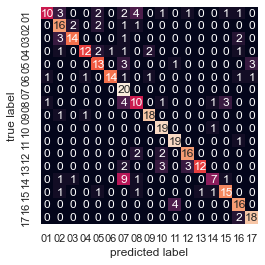

In [65]:
y_pred = np.argmax(predict, axis=1)
print('Confusion Matrix')

mat = confusion_matrix(test_generator.classes, y_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('predicted label')
plt.ylabel('true label');

In [66]:
print(classification_report(test_generator.classes + 1, y_pred + 1))  ## adding 1 to preserve the class naming

              precision    recall  f1-score   support

           1       0.83      0.40      0.54        25
           2       0.62      0.73      0.67        22
           3       0.82      0.70      0.76        20
           4       0.86      0.60      0.71        20
           5       0.65      0.65      0.65        20
           6       0.93      0.70      0.80        20
           7       0.45      1.00      0.62        20
           8       0.53      0.50      0.51        20
           9       0.86      0.90      0.88        20
          10       0.73      0.95      0.83        20
          11       0.79      0.95      0.86        20
          12       0.80      0.80      0.80        20
          13       0.92      0.60      0.73        20
          14       0.70      0.35      0.47        20
          15       0.75      0.75      0.75        20
          16       0.67      0.80      0.73        20
          17       0.82      0.90      0.86        20

    accuracy              

Things to do

- Check some of incorrectly classified images
- Experiment with other models available in Keras
- Build your own network
- Optimize one or several training hyperparameters

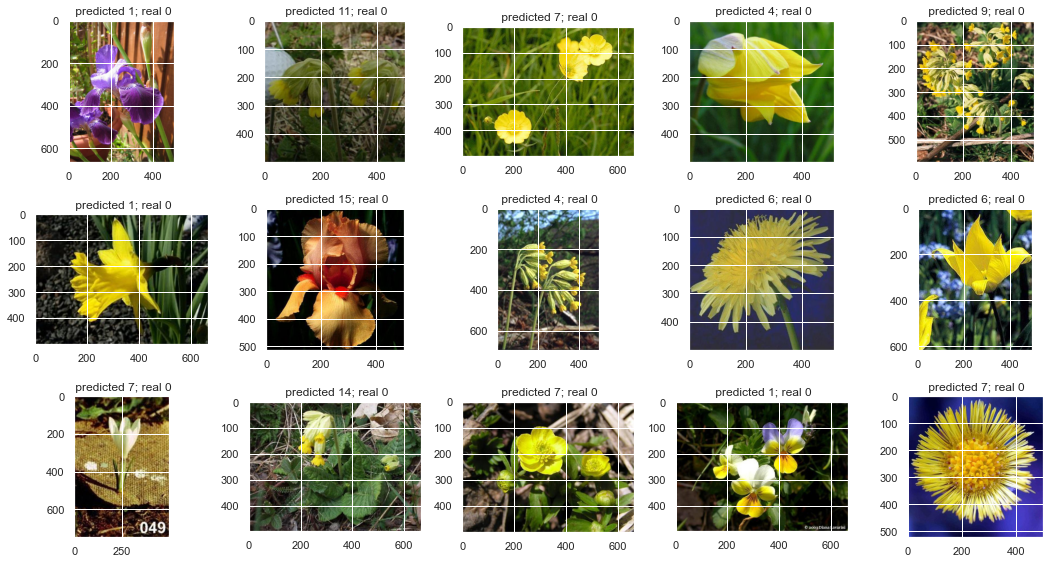

In [67]:
incorect_images = np.array(test_generator.filenames)[test_generator.classes!= y_pred]
incorect_real = test_generator.classes[test_generator.classes!= y_pred]
incorect_pred = y_pred[test_generator.classes!= y_pred]

plt.figure(figsize = (15, 8))
for i, name in enumerate(random.sample(list(incorect_images), 15)):
    plt.subplot(3,5, i+1)
    img = mpimg.imread(os.path.join(data_folder, f'training_folder/test/{name}'))
    plt.title(f' predicted {incorect_pred[i]}; real {incorect_real[i]}')
    plt.imshow(img) 
plt.tight_layout()

In [68]:
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input as preprocess_input_resnet
from keras.callbacks import EarlyStopping

In [79]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape = (112,112,3))
# base_model.summary()

In [80]:
flatten = Flatten()(base_model.output)
dropout_1 = Dropout(0.25)(flatten)
fc_1 = Dense(100)(dropout_1)
dropout_2 = Dropout(0.5)(fc_1)
predictions = Dense(nb_classes, activation="softmax", name='predictions')(dropout_2)
model = Model(inputs=base_model.input, outputs=predictions)

In [81]:
optimizer = optimizers.Adam
learning_rate = 0.0001

In [82]:
model.compile(loss=loss,
              optimizer=optimizer(learning_rate),
              metrics=metrics)

In [83]:
image_size = (112,112)

In [84]:
# apply some data augmentation
train_datagen = ImageDataGenerator(rotation_range=15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   preprocessing_function=preprocess_input_resnet
                                  )

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_resnet) # for validation we don't need to augment

train_batchsize = 5
val_batchsize = 5

# this function takes images from folders and feeds to Imagedatagenerator
train_generator = train_datagen.flow_from_directory( 
        train_dir,
        target_size=image_size,
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        target_size=image_size,
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 680 images belonging to 17 classes.
Found 340 images belonging to 17 classes.


In [85]:
epochs = 100
nb_train_steps = train_generator.samples // train_generator.batch_size
nb_val_steps = validation_generator.samples // validation_generator.batch_size

In [86]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=nb_train_steps,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=nb_val_steps,
      verbose=1, #0
      callbacks = [EarlyStopping(monitor="val_loss", min_delta=1e-2, patience=10)]
)

Epoch 1/100
136/136 [==============================] - 16s 120ms/step - loss: 5.6936 - accuracy: 0.2441 - val_loss: 4.9913 - val_accuracy: 0.5735
Epoch 2/100
136/136 [==============================] - 10s 74ms/step - loss: 3.2445 - accuracy: 0.4779 - val_loss: 5.8907 - val_accuracy: 0.6765
Epoch 3/100
136/136 [==============================] - 10s 74ms/step - loss: 2.0295 - accuracy: 0.6471 - val_loss: 2.9547 - val_accuracy: 0.73820 - accura - ETA: 0s - loss: 2.1012 - ac - ETA: 0s - loss: 2.0696 - accuracy:  - ETA: 0s - loss: 2.0349 - accuracy: 0.64
Epoch 4/100
136/136 [==============================] - 10s 75ms/step - loss: 2.0318 - accuracy: 0.6618 - val_loss: 2.1029 - val_accuracy: 0.7853
Epoch 5/100
136/136 [==============================] - 10s 75ms/step - loss: 1.5227 - accuracy: 0.7132 - val_loss: 4.1367 - val_accuracy: 0.8147
Epoch 6/100
136/136 [==============================] - 10s 75ms/step - loss: 1.3705 - accuracy: 0.7529 - val_loss: 1.8650 - val_accuracy: 0.8059
Epoch 7/1

In [87]:
print('training acc.:',history.history['accuracy'][-1])
print('val acc.:', (history.history['val_accuracy'])[-1])

training acc.: 0.9044118
val acc.: 0.8970588445663452


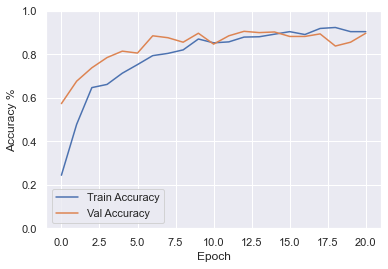

In [88]:
plot_history(history)

#### 3.2 Training enhancement

There are multiple ways to improve the quality of the model. Have a look at these papers that provide some heuristics for training a [classification](https://arxiv.org/pdf/1812.01187.pdf) or [object detection](https://arxiv.org/pdf/1902.04103.pdf) model.

##### 3.2.1 Data augmentation

Better data augmentation can easily give a boost to a model. Some of the useful tools include
- [imgaug](https://github.com/aleju/imgaug)
- [mixup](https://arxiv.org/pdf/1710.09412.pdf)

##### 3.2.2 Learning rate scheduling and early stopping criteria

In Keras learning rate scheduling and early stopping criteria can be implemented using [Callbacks](https://keras.io/callbacks/). In particular, the following are quite useful: LearningRateScheduler, ReduceLROnPlateau, EarlyStopping,  CSVLogger, ModelCheckpoint.